In [ ]:
#mounted google drive in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -rf /content/DermalScan_aging


In [ ]:
#unzipped dataset from drive into colab
!unzip "/content/drive/MyDrive/DermalScan_aging.zip" -d /content/



Archive:  /content/drive/MyDrive/DermalScan_aging.zip
   creating: /content/DermalScan_aging/
   creating: /content/DermalScan_aging/clear_skin/
  inflating: /content/DermalScan_aging/clear_skin/1_0_0_20161219140623097.jpg.chip.jpg  
  inflating: /content/DermalScan_aging/clear_skin/1_0_0_20161219140627985.jpg.chip.jpg  
  inflating: /content/DermalScan_aging/clear_skin/1_0_0_20161219140642920.jpg.chip.jpg  
  inflating: /content/DermalScan_aging/clear_skin/1_0_0_20161219154018476.jpg.chip.jpg  
  inflating: /content/DermalScan_aging/clear_skin/1_0_0_20161219154556757.jpg.chip.jpg  
  inflating: /content/DermalScan_aging/clear_skin/1_0_0_20161219154724341.jpg.chip.jpg  
  inflating: /content/DermalScan_aging/clear_skin/1_0_0_20161219154909149.jpg.chip.jpg  
  inflating: /content/DermalScan_aging/clear_skin/1_0_0_20161219154956869.jpg.chip.jpg  
  inflating: /content/DermalScan_aging/clear_skin/1_0_0_20161219160713534.jpg.chip.jpg  
  inflating: /content/DermalScan_aging/clear_skin/1_0_

In [ ]:
#has set the dataset path
DATASET_PATH = "/content/DermalScan_aging"


In [ ]:
#counted no of images per folder
import os

classes = ["wrinkles", "dark_spots", "puffy_eyes", "clear_skin"]
counts = {}

for cls in classes:
    folder = os.path.join(DATASET_PATH, cls)
    counts[cls] = len(os.listdir(folder))

counts


{'wrinkles': 50, 'dark_spots': 50, 'puffy_eyes': 50, 'clear_skin': 50}

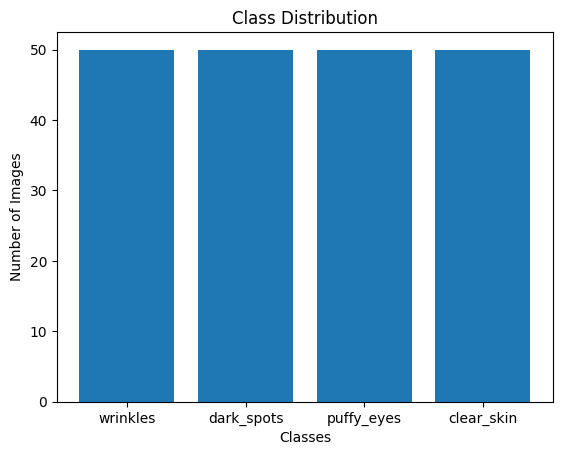

In [ ]:
#created a class distribution graph to show all labels are equal
import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values())
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()


In [ ]:
#preprocessing-resized every image to 224x224 and normalized pixel values by dividing by 255
import cv2
import numpy as np

IMG_SIZE = 224

def preprocess(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img


In [ ]:
#loaded all the images using a loop and stored them in an array called images.
import glob
from tensorflow.keras.utils import to_categorical

images = []
labels = []

label_map = {
    "wrinkles": 0,
    "dark_spots": 1,
    "puffy_eyes": 2,
    "clear_skin": 3
}

for cls in classes:
    folder = os.path.join(DATASET_PATH, cls)
    for img_path in glob.glob(folder + "/*"):
        img = preprocess(img_path)
        images.append(img)
        labels.append(label_map[cls])

images = np.array(images)
labels = to_categorical(labels, num_classes=4)

images.shape, labels.shape


((200, 224, 224, 3), (200, 4))

In [ ]:
#one hot encoding to the labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(images)


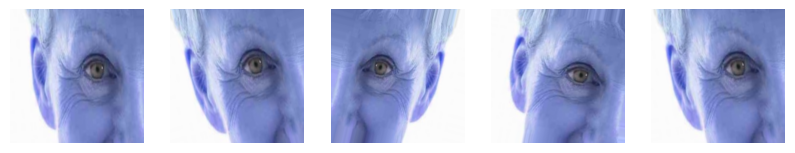

In [ ]:
#image augmentation
import matplotlib.pyplot as plt

sample = images[0].reshape((1,224,224,3))

plt.figure(figsize=(10,3))
for i in range(5):
    aug = datagen.flow(sample, batch_size=1)[0]
    plt.subplot(1,5,i+1)
    plt.imshow(aug[0])
    plt.axis('off')


In [ ]:
#module 3
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.4950 - loss: 1.1044 - val_accuracy: 0.2500 - val_loss: 1.4633
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.8967 - loss: 0.3028 - val_accuracy: 0.3750 - val_loss: 1.7095
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9267 - loss: 0.1967 - val_accuracy: 0.3750 - val_loss: 1.6173
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9881 - loss: 0.0687 - val_accuracy: 0.3750 - val_loss: 1.5505
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9545 - loss: 0.1615 - val_accuracy: 0.3750 - val_loss: 2.4471
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.9842 - loss: 0.0847 - val_accuracy: 0.3750 - val_loss: 2.7946
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9564 - loss: 0.1453 - val_accuracy: 0.3750 - val_loss: 5.6351
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.9643 - loss: 0.1080 - val_accuracy: 0.3750 - val_loss:

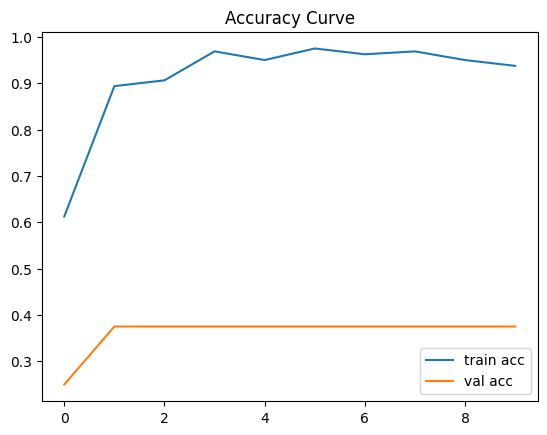

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(); plt.title("Accuracy Curve"); plt.show()


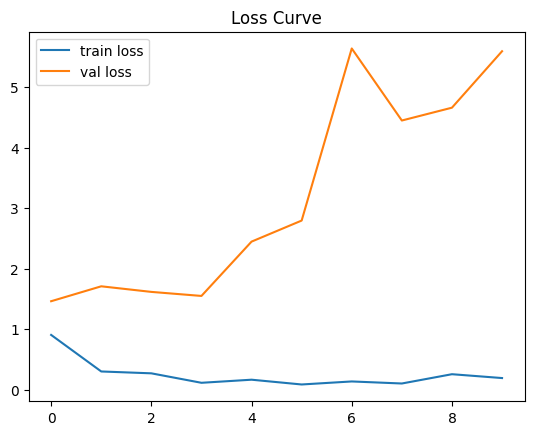

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.title("Loss Curve"); plt.show()


In [ ]:
model.save("DermalScan_Model.h5")


In [ ]:
from google.colab import files
files.download("DermalScan_Model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#module 4
import cv2

# Load Haar Cascade file for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("DermalScan_Model.h5")


In [ ]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [ ]:
import numpy as np

# Replace filename.jpg with the uploaded image name
img = cv2.imread(list(uploaded.keys())[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.1, 4)


In [ ]:
classes = ["wrinkles", "dark_spots", "puffy_eyes", "clear_skin"]

h_img, w_img, _ = img.shape

for (x, y, w, h) in faces:
    # Boundary check
    x1 = max(0, x)
    y1 = max(0, y)
    x2 = min(w_img, x + w)
    y2 = min(h_img, y + h)

    face = img[y1:y2, x1:x2]

    # ❗ Skip empty or tiny faces
    if face.size == 0 or face.shape[0] < 30 or face.shape[1] < 30:
        continue

    face_resized = cv2.resize(face, (224, 224))
    face_norm = face_resized / 255.0
    face_input = face_norm.reshape(1, 224, 224, 3)

    pred = model.predict(face_input, verbose=0)[0]
    predicted_label = classes[np.argmax(pred)]
    confidence = float(np.max(pred)) * 100

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, predicted_label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(img, f"{confidence:.2f}%", (x1, y2 + 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


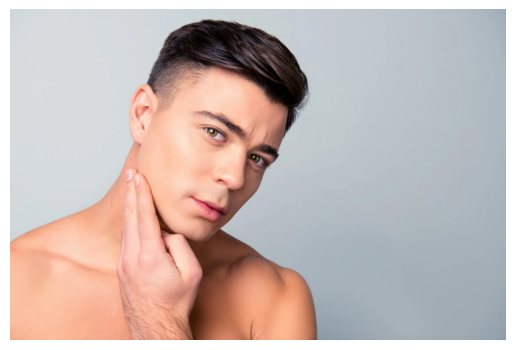

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [ ]:
#module5
import streamlit as st
import cv2
import numpy as np
from tensorflow.keras.models import load_model

st.title("DermalScan – Skin Aging Detection")

st.write("Upload a face image to detect skin condition")

model = load_model("DermalScan_Model.h5")

uploaded_file = st.file_uploader("Upload Image", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, 1)

    st.image(img, caption="Uploaded Image", channels="BGR")

    img_resized = cv2.resize(img, (224, 224))
    img_normalized = img_resized / 255.0
    img_input = img_normalized.reshape(1, 224, 224, 3)

    pred = model.predict(img_input)[0]

    classes = ["wrinkles", "dark_spots", "puffy_eyes", "clear_skin"]
    label = classes[np.argmax(pred)]
    confidence = np.max(pred) * 100

    st.success(f"Prediction: {label}")
    st.info(f"Confidence: {confidence:.2f}%")


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
from google.colab import files
files.download("DermalScan_Model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>